# The DDPM Architecutre

The DDPM paper uses a custom archituecture based off the PixleCNN++ paper, which is based on papers like U-Net and Wide ResNet which we will be breaking down in this notebook. 

## Table of Contents

- [The U-Net](#the-u-net)
- [The DDPM Architecture](#the-ddpm-architecutre)
- [GroupNorm](#groupnorm)
- [Sinusoidal Time Embeddings](#sinusoidal-time-embeddings)
- [Sigmoid Linear Unit](#sigmoid-linear-unit)
- [Self-Attention and the Attention Block](#self-attention-and-the-attention-block)
- [Downsampling block](#downsampling-block)
- [MidBlock (Bottleneck)](#midblock-bottneck)
- [Upsampling block](#upsampling-block)
- [Putting everything together](#putting-everything-together)

# The U-Net

At the high level, the shape of the DDPM network resembles the U-Net architecture, pictured below. The U-Net, like ResNet, is mostly composed of convolutional layers, but ResNets were developed for classifying an image as a whole, whereas U-Net was developed for medical segmentation tasks that predict an output class such as "this is part of a tumour" for each input pixel in the image. By combining both U-Net and ResNet, the DDPM network has to both get an understanding of the global structure of the image (like ResNet), and also the ability to make fine-grained predictions at the pixel level (like U-Net).

<img src="references/U-Net Architecture.png" alt="U-Net Architecture">
<figcaption><code>Fig. 1</code> from Ronneberger et al. (2015) in <a href="https://arxiv.org/pdf/1505.04597#page=2">U-Net: Convolutional Networks for Biomedical Image Segmentation</a></figcaption>

In the diagram, the grey rectanges represent tensors where the width of the rectangle is the number of channels (i.e. initally 3 channels for RGB images), and the height of the rectangle being the number of spatial dimensions (i.e. initally heigh x width dimensions).

The U-Net can be divided into three main parts:
- **Downsampling** part (as called the "Encoder") - Starts at the very left of the diagram until reaching the bottom. Each downsampling block represents applying some convolutional layers followed by a max pooling downsampling operation, progressively reducing spaital dimensions while increasing the number of channels.
- **Bottleneck** part - Represented by the bottom row of the diagram. Just a couple of convolutions that represent the most compressed represntation. Has the highest number of channels and the lowest number of spatial dimensions. 
- **Upsampling** part (as called the "Decoder") - Starts at the last tensor on the bottom row until the very right of the diagram. Each upsampling block represents applying some convolution layers followed by a **transposed convolution** upsampling operation, progressively increasing the spatial dimensions while decreasing the number of channels. Also, uses skip connections from the **downsampling** part to bring back low level spatial details and combines them with high level features from the deeper layers. 

While regular convolutions perform a sliding window operation where the input values are combined into producing a single output value, transposed convolutions do the opposite - each input value contribute to multiple output values through the kernel weights ("spreading out" the in put values).


<img src="references/transposed_conv.png" alt="Transposed Convolution" width="911" height="298">
<figcaption><code>Fig. 14.10.1</code> in <a href="https://d2l.ai/chapter_computer-vision/transposed-conv.html">Dive into Deep Learning</a></figcaption>


Finally, there is a final convolution that converts the latents back to the desired number of ouput channels. In the case of medical segmentation, there would be one channel for each class of tumor that you want to detect. In the case of image diffusion models, there will be 1 or 3 output channels (greyscale or RGB).

# The DDPM Architecture

<img src="references/DDPM-architecture.png" 
alt="U-Net Architecture\"
data-mermaid="
graph TD
    subgraph DDPM Architecture
        subgraph Overview
            MTime[Num Noise Steps] --> MTimeLayer[SinusoidalEmbedding<br/>Linear: Steps -> 4C<br/>GELU<br/>Linear: 4C -> 4C]
            MTimeLayer -->|emb|DownBlock0 & DownBlock1 & DownBlock2 & MidBlock & UpBlock0 & UpBlock1 & OutBlock
            Image -->|3, H| InConv[7x7 Conv<br/>Padding 3] -->|C, H| DownBlock0 -->|C, H/2| DownBlock1 -->|2C,H/4| DownBlock2 -->|4C,H/4| MidBlock -->|4C,H/4| UpBlock0 -->|2C,H/2| UpBlock1 -->|C,H| OutBlock[Residual Block] -->|C,H| FinalConv[1x1 Conv] -->|3,H| Output
            DownBlock2 -->|4C,H/4| UpBlock0
            DownBlock1 -->|2C,H/2| UpBlock1
        end
end
">

The model used in the paper, shown above, looks very similar to the U-Net. It has the same three part stucture with **downsampling** parts (DownBlocks), a **bottleneck** part (MidBlock), and **upsampling** parts (Upblocks). However, the DDPM architecture also has many differences. The most notable difference is, in addition to the an image input, there is also a single integer represeting the number of steps of noise added. Other differences in the DDPM model include: group normalization, sinusoidal time embeddings, new nonlineararities (SiLu), Self-attention, and residual connections instead of concatenation for skip connections. 

We will dive deeper and implemenet each part of this architecture separately in this notebooks and then finally put everything together at the end. 



In [10]:
from typing import Optional, Union
import matplotlib.pyplot as plt
import torch as t
from einops import rearrange
from fancy_einsum import einsum
from torch import nn
import tests.part2_unet_architecture_tests

# GroupNorm

<img src="references/groupnorm.png" alt="GroupNorm">
<figcaption><code>Fig. 2</code> from Wu and He (2018) in <a href="https://arxiv.org/pdf/1803.08494#page=3">Group Normalization</a></figcaption>

In our previous "toy model" notebook, we had a **Layer Normalization** that preprocessed each training example by computing the mean and standard deviation across all channels.

In **Group Normalization** we divide our chanels into some number of groups, and we calculate the mean and standard deviation for each training example AND group. For exmaple, when the number of groups is 1, GroupNorm is can be expressed to LayerNorm. The main difference being that while LayerNorm expects the channel embedding to be last (the PyTorch convention for NLP), GroupNorm expects the channel dimension to be right after the batch dimensions (the PyTorch convention for images).

The core concept for Group norm is that it divides channels into groups and normalizes within each group for each sample independently. Features within channels often have meanintful relationships (i.e. edge detectors or color channels), by grouping channels together, we maintain these relatinoships while getting the benefits of normalization. In addition, we get more benefits like batch-size independence and more stable training. 

For more intuition, read the paper [Group Normalization](https://arxiv.org/pdf/1803.08494). Also, see [pytorch implementation](https://pytorch.org/docs/stable/_modules/torch/nn/modules/normalization.html#GroupNorm).

In [11]:
class GroupNorm(nn.Module):
    def __init__(
        self,
        num_groups: int,
        num_channels: int,
        eps: float = 1e-5,
        affine: bool = True, 
        device: Optional[Union[t.device, str]] = None,
        dtype: Optional[t.dtype] = None,
    ) -> None:
        super().__init__()
        assert num_channels % num_groups == 0
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.affine = affine # if true, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases)
        if self.affine:
            self.weight = nn.Parameter(t.empty((self.num_channels,), device=device, dtype=dtype))  
            self.bias = nn.Parameter(t.empty((self.num_channels,), device=device, dtype=dtype)) 
        else:
            self.register_parameter("weight", None)
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the weight and bias, if applicable."""
        if self.affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply normalization to each group of channels.

        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        # split into groups
        x = rearrange(x, "n (g c) h w -> n g c h w", g=self.num_groups) 

        # calculate mean and variance
        dim = (2, 3, 4)
        mean = x.mean(dim=dim, keepdim=True)
        var = x.var(dim=dim, keepdim=True, unbiased=False)

        # normalize
        x = x - mean
        x = x / ((var + self.eps) ** 0.5)

        # reassemble to original shape
        x = rearrange(x, "n g c h w -> n (g c) h w")

        # apply learned scale (weight) and bias parameters per-channel if affine=True
        if self.affine:
            x = x * self.weight.view(1, -1, 1, 1)
            x = x + self.bias.view(1, -1, 1, 1)
        return x

In [12]:
tests.part2_unet_architecture_tests.test_groupnorm(GroupNorm, affine=False)
tests.part2_unet_architecture_tests.test_groupnorm(GroupNorm, affine=True)

tests.part2_unet_architecture_tests.test_groupnorm passed in 0.50s.
tests.part2_unet_architecture_tests.test_groupnorm passed in 0.00s.


# Sinusoidal Time Embeddings

In BERT and GPT, the mapping from the sequence position to the embedding vector was learned by the model during training. However, it is also common to simply hardcode this mapping using a combination of sine and cosine functions at different frequences. By hardcoding the mapping, we slightly reduce the nubmer of paramters without sacrificing much performance. 

In our model, instead of sequence position, our model needs to know the number of noise steps were added to be able to anticipate how much noise to expect since the amount of noise increases with number of steps.

TLDR - Sinusoidal embeddings allows a simple linear transformation in of the "query" and "key" vectors can express relative positional relationships (i.e. this positions attends to information k positions ago). For more intuition, see [this blog post](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). We will be reproducing, Figure 2 and Figure 3 from this blog.



<img src="references/positional_embedding.png" alt="Positional Embedding">
<figcaption>From Calvo (2018) in <a href="https://medium.com/dissecting-bert/dissecting-bert-part-1-d3c3d495cdb3">Dissecting BERT Part 1: The Encoder</a> (different blog post from the one previously mentioned)</figcaption>

In [13]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_size: int):
        super().__init__()
        self.embedding_size = embedding_size
        wk = 1.0 / 10000.0 ** ((t.arange(0, embedding_size, 2)) / embedding_size)
        self.register_buffer("wk", wk)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, ) - for each batch element, the number of noise steps
        Out: shape (batch, embedding_size)
        """
        wkx = t.einsum("x, k -> xk", x, self.wk)
        stacked = t.stack((wkx.sin(), wkx.cos()), dim=-1)
        flat = rearrange(stacked, "batch k func -> batch (k func)", func=2)
        return flat

[Text(0.5, 0, 'Num Steps'),
 Text(0, 0.5, 'Num Steps'),
 Text(0.5, 1.0, 'Dot product of position embeddings')]

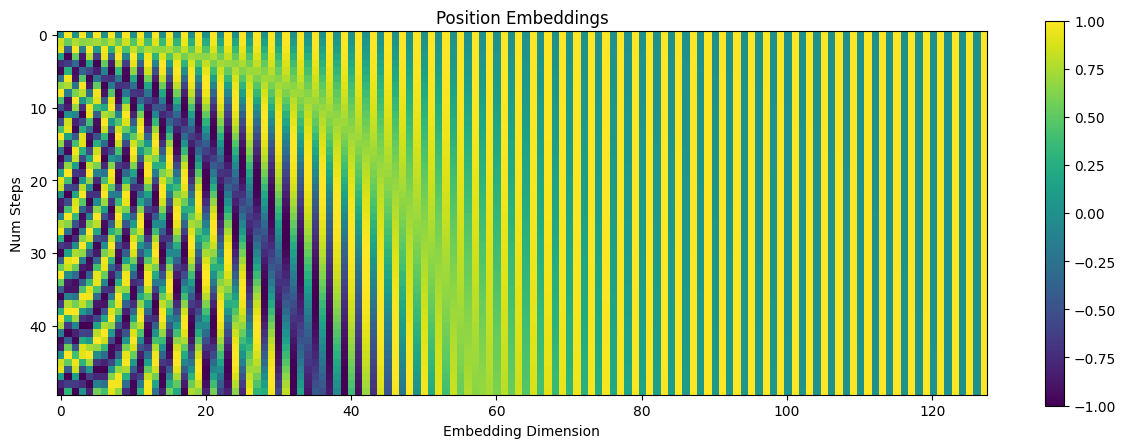

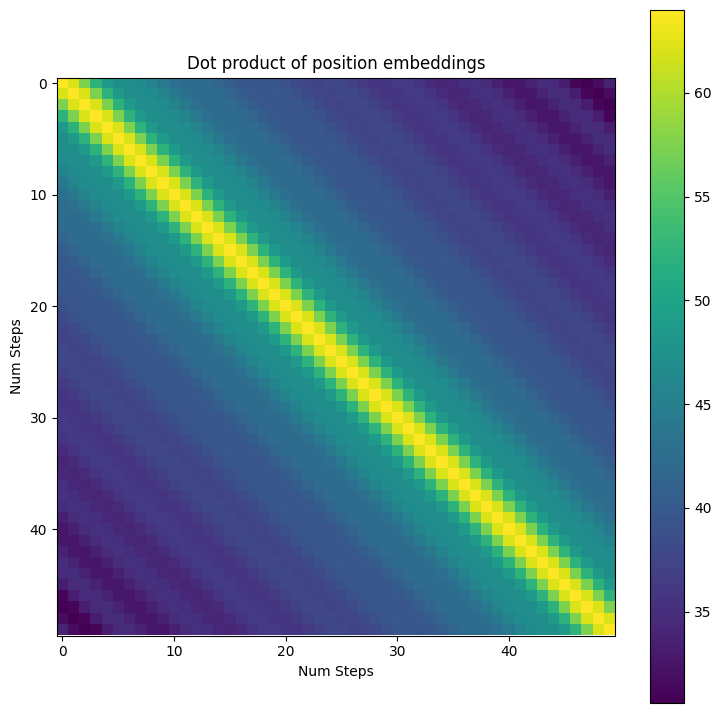

In [14]:
emb = SinusoidalPositionEmbeddings(128)
out = emb(t.arange(50))

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(xlabel="Embedding Dimension", ylabel="Num Steps", title="Position Embeddings")
im = ax.imshow(out, vmin=-1, vmax=1)
fig.colorbar(im)

fig, ax = plt.subplots(figsize=(9, 9))
im = ax.imshow(out @ out.T)
fig.colorbar(im)
ax.set(xlabel="Num Steps", ylabel="Num Steps", title="Dot product of position embeddings")

# Sigmoid Linear Unit

The Sigmoid Linear Unit (SiLu) (also sometimes called "Swish") nonlinearity is simply elementwise `x * sigmoid(x)`. 

TLDR: It's just another activation function that claims to lead to better performance. For more details about this activation function, [Swish: A Self-Gated Activation Function](https://arxiv.org/pdf/1710.05941v1).

In [15]:
def swish(x: t.Tensor) -> t.Tensor:
    return x * x.sigmoid()


class SiLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return swish(x)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'swish(x)')]

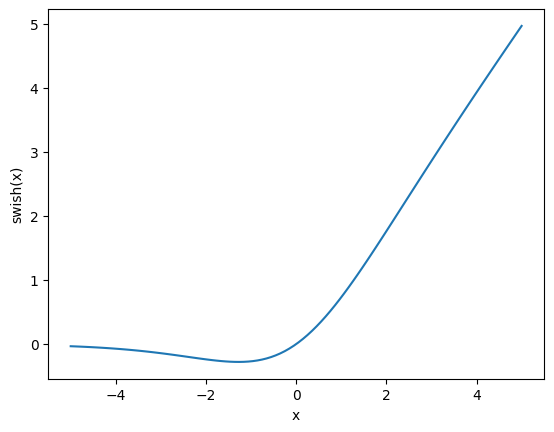

In [16]:
silu = SiLU()


fig, ax = plt.subplots()
x = t.linspace(-5, 5, 100)
ax.plot(x, silu(x))
ax.set(xlabel="x", ylabel="swish(x)")

# Self-Attention and the Attention Block

<img src="references/self_attention.png" alt="Multi-Head Attention">
<figcaption><code>Figure 2</code> from Vaswani et al. (2017) in <a href="https://arxiv.org/pdf/1706.03762#page=4">Attention Is All You Need</a></figcaption>

The self-attention mechanism in the DDPM model look very similar to the self-attention mechanism used in LLMs like GPT. However, in the DDPM model, there is no causal attnetion meaning that we don't need to apply as mask. Also, instead of having only one spatial dimension (token sequences), we have image data that has two spatial dimensions (height and width). 


In [17]:
class SelfAttention(nn.Module):
    def __init__(self, channels: int, num_heads: int = 4):
        """Self-Attention with two spatial dimensions.

        channels: the number of channels. Should be divisible by the number of heads.
        """
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0
        self.head_size = channels // num_heads
        self.in_proj = nn.Linear(channels, channels * 3) # 3 for Key (W_K), Query (W_Q), and Value (W_V) vectors
        self.out_proj = nn.Linear(channels, channels) # Ouput (W_O)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        out: shape (batch, channels, height, width)
        """
        b, c, h, w = x.shape
        assert self.channels == c

        # Reshape 2D image into sequence of feature vectors
        x = rearrange(x, "batch channels height width -> batch (height width) channels") 

        # Project input into query, key, and value vectors all at once
        qkv = self.in_proj(x).chunk(3, dim=-1)

        # Separate Q, K, V and reshape to split channels into multiple heads
        q, k, v = [
            rearrange(tensor, "batch seq (head head_size) -> batch head seq head_size", head=self.num_heads)
            for tensor in qkv
        ]

        # Compute and scale attention scores 
        out = einsum("batch head seq_q head_size, batch head seq_k head_size -> batch head seq_q seq_k", q, k)
        out = out / (self.head_size**0.5)
        attn = out.softmax(dim=-1)

        # Use attention probabilties to computed a weighted sum of values 
        out = einsum("batch head seq_k head_size, batch head seq_q seq_k -> batch head seq_q head_size", v, attn)

        # Combine all heads and restore original sequence dimension
        out = rearrange(out, "batch head seq head_size -> batch seq (head head_size)")

        # Final projection to mix information between heads
        out = self.out_proj(out)

        # Reshape back into a 2D image 
        out = rearrange(out, "batch (height width) channels -> batch channels height width", height=h, width=w)

        return out

In [18]:
tests.part2_unet_architecture_tests.test_self_attention(SelfAttention)

tests.part2_unet_architecture_tests.test_self_attention passed in 0.08s.


Below is a diagram of the AttentionBlock. It is pretty straight forward. There is a GroupNorm layer, followed the self-attention layer implemented above that gets added back to the residual stream at the very end.

<img src="references/attention_block.png" alt="Attention Block
graph TD
    subgraph AttentionBlock
        Image --> GroupNorm[Group Norm<br/>1 group] --> Self-Attention[Self-Attention<br/>4 heads] --> Output
        Image --> Output
    end"
 width="322.33333333" height="640">

In [19]:
class AttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.norm = GroupNorm(1, channels)
        self.attn = SelfAttention(channels)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return x + self.attn(self.norm(x))

In [20]:
tests.part2_unet_architecture_tests.test_attention_block(SelfAttention)

tests.part2_unet_architecture_tests.test_attention_block passed in 0.07s.


In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, step_dim: int, groups: int):
        """
        input_channels: number of channels in the input to foward
        output_channels: number of channels in the returned output
        step_dim: embedding dimension size for the number of steps
        groups: number of groups in the GroupNorms

        Note that the conv in the left branch is needed if c_in != c_out.
        """
        super().__init__()
        self.mlp = nn.Sequential(
            SiLU(), nn.Linear(step_dim, output_channels)
        )  # start with silu because time_mlp in the base ended in Linear without nonlinearity

        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, padding=1), GroupNorm(groups, output_channels), SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, padding=1), GroupNorm(groups, output_channels), SiLU()
        )
        self.res_conv = (
            nn.Conv2d(input_channels, output_channels, 1) if input_channels != output_channels else nn.Identity() # extra convolution to get the input/output dimensions to match
        )

    def forward(self, x: t.Tensor, time_emb: t.Tensor) -> t.Tensor:
        h = self.block1(x)

        time_emb = self.mlp(time_emb)
        h = rearrange(time_emb, "b c -> b c 1 1") + h # matching up matrix dimensions
        h = self.block2(h)
        return h + self.res_conv(x)

In [22]:
tests.part2_unet_architecture_tests.test_residual_block(ResidualBlock)

tests.part2_unet_architecture_tests.test_residual_block passed in 0.01s.


# Downsampling Block

The downblock takes in an input with height `h` and an embedding for the number of steps `NumSteps` and returns: a skip output of height `h` to the corresponding `UpBlock` **AND** a dampsampled output of height `h//2`

<img src="references/down_block.png" alt="Down Block"
data-mermaid="
graph TD
    subgraph DownBlock
        NumSteps -->|emb| DResnetBlock1 & DResnetBlock2
        DImage[Input] -->|c_in, h| DResnetBlock1[Residual Block 1] -->|c_out, h| DResnetBlock2[Residual Block 2] -->|c_out, h| DAttention[Attention Block] -->|c_out, h| DConv2d[4x4 Conv<br/>Stride 2<br/>Padding 1] -->|c_out, h/2| Output
        DAttention -->|c_out, h| SkipToUpBlock[Skip To<br/>UpBlock]
    end
" width="277" height="640">

In [23]:
class DownBlock(nn.Module):
    def __init__(
        self,
        channels_in: int,
        channels_out: int,
        time_emb_dim: int,
        groups: int,
        downsample: bool,
    ):
        super().__init__()
        self.block0 = ResidualBlock(channels_in, channels_out, time_emb_dim, groups)
        self.block1 = ResidualBlock(channels_out, channels_out, time_emb_dim, groups)
        self.attn = AttentionBlock(channels_out)
        self.downsample = nn.Conv2d(channels_out, channels_out, 4, 2, 1) if downsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        """
        x: shape (batch, channels, height, width)
        step_emb: shape (batch, emb)
        Return: (downsampled output, full size output to skip to matching UpBlock)
        """
        B, C, H, W = x.shape
        x = self.block0(x, step_emb)
        x = self.block1(x, step_emb)
        skip = self.attn(x)
        if isinstance(self.downsample, nn.Conv2d):
            assert H % 2 == 0, f"{H} not divisible by 2 - this will break the upsample later"
            assert W % 2 == 0, f"{W} not divisible by 2 - this will break the upsample later"
        x = self.downsample(skip)
        return x, skip


In [24]:
tests.part2_unet_architecture_tests.test_downblock(DownBlock, downsample=True)
tests.part2_unet_architecture_tests.test_downblock(DownBlock, downsample=False)


tests.part2_unet_architecture_tests.test_downblock passed in 0.01s.
tests.part2_unet_architecture_tests.test_downblock passed in 0.00s.


# MidBlock (Bottneck)

<img src="references/up_block.png" alt="Mid Block"
data-mermaid="
graph TD
    subgraph MidBlock
        UNumSteps[NumSteps] -->|emb| UResnetBlock1 & UResnetBlock2
        UImage[Image] -->|c_mid, h| UResnetBlock1[Residual Block 1] -->|c_mid, h| UAttention[Attention Block] -->|c_mid, h| UResnetBlock2[Residual Block 2] -->|c_mid, h| UOutput[Output]
    end
" width="345.3" height="640">

After passing through all the `DownBlocks`, the image tensor is passed through `MidBlocks` which doesn't modify the tensor dimensions. 

In [25]:
class MidBlock(nn.Module):
    def __init__(self, mid_dim: int, time_emb_dim: int, groups: int):
        super().__init__()
        self.mid_block1 = ResidualBlock(mid_dim, mid_dim, time_emb_dim, groups)
        self.mid_attn = AttentionBlock(mid_dim)
        self.mid_block2 = ResidualBlock(mid_dim, mid_dim, time_emb_dim, groups)

    def forward(self, x: t.Tensor, step_emb: t.Tensor):
        x = self.mid_block1(x, step_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, step_emb)
        return x

In [26]:
tests.part2_unet_architecture_tests.test_midblock(MidBlock)

tests.part2_unet_architecture_tests.test_midblock passed in 0.00s.


# Upsampling Block

<img src="references/up_block.png" alt="Up Block"
data-mermaid="
graph TD
    subgraph UpBlock
        UNumSteps[NumSteps] -->|emb| UResnetBlock1 & UResnetBlock2
        Skip[Skip From<br/>DownBlock<br/>] -->|c_out, h| Concatenate
        UImage[Image] -->|c_out, h| Concatenate -->|2*c_out, h| UResnetBlock1[Residual Block 1] -->|c_in, h| UResnetBlock2[Residual Block 2] -->|c_in, h| UAttention[Attention Block] -->|c_in, h| DConvTranspose2d[4x4 Transposed Conv<br/>Stride 2<br/>Padding 1] -->|c_in, 2h| UOutput[Output]
    end
" width="301" height="640">

In addition to `NumSteps` and the image data, the `UpBlock` also takes in a skip connection from the corresponding `DownBlock` (i.e. the first `UpBlock` corresponds to the last `DownBlock`, second `UpBlock` corresponds to the second to last `DownBlock`, etc).

Note: The shape dimensions `c_in` and `c_out` are with respect to the corresponding `DownBlock`. It's confusing either way you try to label it.

In [27]:
class UpBlock(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, time_emb_dim: int, groups: int, upsample: bool):
        super().__init__()
        self.block0 = ResidualBlock(dim_out * 2, dim_in, time_emb_dim, groups)
        self.block1 = ResidualBlock(dim_in, dim_in, time_emb_dim, groups)
        self.attn = AttentionBlock(dim_in)
        self.upsample = nn.ConvTranspose2d(dim_in, dim_in, 4, 2, 1) if upsample else nn.Identity()

    def forward(self, x: t.Tensor, step_emb: t.Tensor, skip: t.Tensor) -> t.Tensor:
        x = t.cat((x, skip), dim=1)  # cat along channel dim
        x = self.block0(x, step_emb)
        x = self.block1(x, step_emb)
        x = self.attn(x)
        x = self.upsample(x)
        return x

In [28]:
tests.part2_unet_architecture_tests.test_upblock(UpBlock, upsample=True)
tests.part2_unet_architecture_tests.test_upblock(UpBlock, upsample=False)

tests.part2_unet_architecture_tests.test_upblock passed in 0.00s.
tests.part2_unet_architecture_tests.test_upblock passed in 0.00s.


# Putting everything together

Now that we have implemented all of the pieces, we can put stitch together the entire model. Here is the high level diagram of the DDPM model again:

<img src="references/DDPM-architecture.png" 
alt="U-Net Architecture\"
data-mermaid="
graph TD
    subgraph DDPM Architecture
        subgraph Overview
            MTime[Num Noise Steps] --> MTimeLayer[SinusoidalEmbedding<br/>Linear: Steps -> 4C<br/>GELU<br/>Linear: 4C -> 4C]
            MTimeLayer -->|emb|DownBlock0 & DownBlock1 & DownBlock2 & MidBlock & UpBlock0 & UpBlock1 & OutBlock
            Image -->|3, H| InConv[7x7 Conv<br/>Padding 3] -->|C, H| DownBlock0 -->|C, H/2| DownBlock1 -->|2C,H/4| DownBlock2 -->|4C,H/4| MidBlock -->|4C,H/4| UpBlock0 -->|2C,H/2| UpBlock1 -->|C,H| OutBlock[Residual Block] -->|C,H| FinalConv[1x1 Conv] -->|3,H| Output
            DownBlock2 -->|4C,H/4| UpBlock0
            DownBlock1 -->|2C,H/2| UpBlock1
        end
end
">


In [29]:
class Unet(nn.Module):
    def __init__(
        self,
        image_shape: tuple[int, int, int],
        channels: int = 128,
        dim_mults: tuple[int, ...] = (1, 2, 4, 8),
        groups: int = 4,
        max_steps: int = 1000,
    ):
        """
        image_shape: the input and output image shape, a tuple of (C, H, W)
        channels: the number of channels after the first convolution.
        dim_mults: the number of output channels for downblock i is dim_mults[i] * channels. Note that the default arg of (1, 2, 4, 8) will contain one more DownBlock and UpBlock than the DDPM image above.
        groups: number of groups in the group normalization of each ResnetBlock (doesn't apply to attention block)
        max_steps: the max number of (de)noising steps. We also use this value as the sinusoidal positional embedding dimension (although in general these do not need to be related).
        """
        self.noise_schedule = None
        self.img_shape = image_shape
        super().__init__()
        time_emb_dim = 4 * channels
        self.init_conv = nn.Conv2d(image_shape[0], channels, 7, padding=3)
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(max_steps),
            nn.Linear(max_steps, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        dims = [channels] + [channels * m for m in dim_mults]
        in_out = list(zip(dims[:-1], dims[1:]))
        print("Channel sizes for in/out:", in_out) 

        self.downs = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(in_out):
            is_last = i >= len(in_out) - 1
            self.downs.append(DownBlock(dim_in, dim_out, time_emb_dim, groups, not is_last))

        self.mid = MidBlock(dims[-1], time_emb_dim, groups)

        self.ups = nn.ModuleList([])
        for i, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = i >= len(in_out) - 1
            self.ups.append(UpBlock(dim_in, dim_out, time_emb_dim, groups, not is_last))

        self.final_block = ResidualBlock(channels, channels, time_emb_dim, groups)
        self.final_conv = nn.Conv2d(channels, image_shape[0], 1)

    def forward(self, x: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        x: shape (batch, channels, height, width)
        num_steps: shape (batch, )

        out: shape (batch, channels, height, width)
        """
        x = self.init_conv(x)
        step_emb = self.time_mlp(num_steps)
        skips = [] # push/pop to match `UpBlocks` to `DownBlocks`
        for d in self.downs:
            assert isinstance(d, DownBlock)
            x, skip = d(x, step_emb)
            skips.append(skip)

        x = self.mid(x, step_emb)

        for u in self.ups:
            assert isinstance(u, UpBlock)
            skip = skips.pop()
            x = u(x, step_emb, skip)

        x = self.final_block(x, step_emb)
        x = self.final_conv(x)
        return x

In [30]:
tests.part2_unet_architecture_tests.test_unet(Unet)

Channel sizes for in/out: [(8, 8), (8, 16), (16, 32)]
tests.part2_unet_architecture_tests.test_unet passed in 0.05s.


In [31]:
import os
from pathlib import Path
from typing import Any
import numpy as np
import torch as t
import torchvision
from einops import rearrange, repeat
from IPython.display import display
from PIL import Image
from scipy import linalg
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import CenterCrop, Compose, Lambda, RandomHorizontalFlip, Resize, ToPILImage, ToTensor
from tqdm.auto import tqdm
from part1_toy_model import NoiseSchedule, sample, train

torch_device = 'cuda' if t.cuda.is_available() else "mps" if t.backends.mps.is_available() else "cpu"

def make_transform(image_size=128):
    """Pipeline from PIL Image to Tensor."""
    return Compose([Resize(image_size), CenterCrop(image_size), ToTensor(), Lambda(lambda t: t * 2 - 1)])


def make_reverse_transform():
    """Pipeline from Tensor to PIL Image."""
    return Compose(
        [
            Lambda(lambda t: (t + 1) / 2),
            Lambda(lambda t: t.permute(1, 2, 0)),
            Lambda(lambda t: t * 255.0),
            Lambda(lambda t: t.clamp(0, 255)),
            Lambda(lambda t: t.numpy().astype(np.uint8)),
            ToPILImage(),
        ]
    )

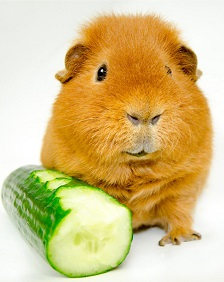

In [32]:
transform = make_transform()
reverse_transform = make_reverse_transform()
image = Image.open("./clip_images/guineapig_cucumber.jpg")
x = transform(image)
display(image)

In [33]:
def get_fashion_mnist(train_transform, test_transform) -> tuple[TensorDataset, TensorDataset]:
    """Return MNIST data using the provided Tensor class."""
    mnist_train = datasets.FashionMNIST("../data", train=True, download=True)
    mnist_test = datasets.FashionMNIST("../data", train=False)
    print("Preprocessing data...")
    train_tensors = TensorDataset(
        t.stack([train_transform(img) for (img, label) in tqdm(mnist_train, desc="Training data")])
    )
    test_tensors = TensorDataset(t.stack([test_transform(img) for (img, label) in tqdm(mnist_test, desc="Test data")]))
    return (train_tensors, test_tensors)


In [34]:
train_transform = Compose([ToTensor(), RandomHorizontalFlip(), Lambda(lambda t: t * 2 - 1)])
data_folder = Path("data/w3d4")
data_folder.mkdir(exist_ok=True, parents=True)
DATASET_FILENAME = data_folder / "generative_models_dataset_fashion.pt"
if DATASET_FILENAME.exists():
    (train_dataset, test_dataset) = t.load(str(DATASET_FILENAME))
else:
    (train_dataset, test_dataset) = get_fashion_mnist(train_transform, train_transform)
    t.save((train_dataset, test_dataset), str(DATASET_FILENAME))

/var/folders/sm/byz3skxx5c57sw2mzmy66j240000gn/T/ipykernel_63010/2678874312.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  (train_dataset, test_dataset) = t.load(str(DA

In [35]:
config_dict: dict[str, Any] = dict(
    model_channels=28,
    model_dim_mults=(1, 2, 4),
    image_shape=(1, 28, 28),
    max_steps=1000,
    epochs=10,
    lr=0.001,
    batch_size=128,
    img_log_interval=400,
    n_images_to_log=3,
    device=torch_device,
    enable_wandb=False
)

In [36]:
model = Unet(
    max_steps=config_dict["max_steps"],
    channels=config_dict["model_channels"],
    image_shape=config_dict["image_shape"],
    dim_mults=config_dict["model_dim_mults"],
).to(config_dict["device"])
assert isinstance(data_folder, Path)
MODEL_FILENAME = data_folder / "unet_model_thousand.pt"
if MODEL_FILENAME.exists():
    model = Unet(
        max_steps=config_dict["max_steps"],
        channels=config_dict["model_channels"],
        image_shape=config_dict["image_shape"],
        dim_mults=config_dict["model_dim_mults"],
    ).to(config_dict["device"])
    model.noise_schedule = NoiseSchedule(config_dict["max_steps"], config_dict["device"])
    model.load_state_dict(t.load(str(MODEL_FILENAME)))
else:
    print("Training model from scratch!")
    model = train(model, config_dict, train_dataset, test_dataset)
    t.save(model.state_dict(), str(MODEL_FILENAME))

Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]
Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]


/var/folders/sm/byz3skxx5c57sw2mzmy66j240000gn/T/ipykernel_63010/1780550070.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(str(MODEL_FILEN

In [37]:
from huggingface_hub import HfApi, login
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Initialize API
api = HfApi()

# Login using token from .env
login(token=os.getenv('HUGGINGFACE_API_TOKEN'))

# Rest of your upload code...
api.upload_file(
    path_or_fileobj="./data/w3d4/unet_model_thousand.pt",
    path_in_repo="ddpm-fashionmnist.pt",
    repo_id="michaelyliu6/ddpm-fashionmnist",
    repo_type="model",
    create_pr=False
)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/michaelyliu6/ddpm-fashionmnist/commit/f7edfe931a1893c7c17aad8a88121e9290b33d6f', commit_message='Upload ddpm-fashionmnist.pt with huggingface_hub', commit_description='', oid='f7edfe931a1893c7c17aad8a88121e9290b33d6f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/michaelyliu6/ddpm-fashionmnist', endpoint='https://huggingface.co', repo_type='model', repo_id='michaelyliu6/ddpm-fashionmnist'), pr_revision=None, pr_num=None)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import wandb

# 1. Initialize W&B
wandb.init(project="fashionmnist-cnn-pytorch-fast", entity="your_wandb_entity")  # Replace with your W&B entity

# 2. Define the CNN Model (ResNet-inspired)
class FastFashionCNN(nn.Module):
    def __init__(self):
        super(FastFashionCNN, self).__init__()

        # Building block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm 
        def conv_block(in_channels, out_channels, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Downsampling (if needed to match dimensions for shortcut connection)
        def downsample_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.layer1 = conv_block(1, 32)  # No downsampling here
        self.layer2 = conv_block(32, 64, stride=2)
        self.layer3 = conv_block(64, 128, stride=2)
        
        self.downsample2 = downsample_block(32, 64)
        self.downsample3 = downsample_block(64, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        identity = x
        x = self.layer1(x)
        
        identity = self.downsample2(x)
        x = self.layer2(x)
        x += identity
        x = nn.ReLU(inplace=True)(x)
        
        identity = self.downsample3(x)
        x = self.layer3(x)
        x += identity
        x = nn.ReLU(inplace=True)(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.fc(x)
        return x

# 3. Load and Prepare the Data (with Data Augmentation and Normalization)
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST-specific normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST-specific normalization
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True) # Increased batch size, num_workers
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4, pin_memory=True)

# 4. Instantiate the Model, Loss Function, and Optimizer
model = FastFashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2) # AdamW optimizer

# 5. One-Cycle Learning Rate Scheduler
epochs = 20 # Reduced number of epochs because of the better scheduler
total_steps = len(train_loader) * epochs
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

# 6. Log hyperparameters to W&B
wandb.config.update({
    "learning_rate": 0.001, 
    "max_lr": 0.01,       
    "epochs": epochs,
    "batch_size": 128,
    "weight_decay": 1e-2,
    "architecture": "FastFashionCNN",
    "optimizer": "AdamW"
})

# 7. Train the Model
device = 'cuda' if t.cuda.is_available() else "mps" if t.backends.mps.is_available() else "cpu"
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step() # Update learning rate per batch

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            wandb.log({"train_loss": loss.item(), "lr": scheduler.get_last_lr()[0]})

    # 8. Evaluate the Model
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")

    wandb.log({"test_loss": test_loss, "test_accuracy": accuracy})

# 9. Watch the model
wandb.watch(model, log="all", log_freq=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: michaelyliu6. Use `wandb login --relogin` to force relogin


CommError: failed to upsert bucket: returned error 404 Not Found: {"errors":[{"message":"entity your_wandb_entity not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}

In [35]:
import torch as t
from tqdm import tqdm
from typing import Union

def sample_ddim(model, n_samples: int, steps: int, eta: float = 0.0, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    """
    Sample using DDIM, which can be much faster than DDPM.

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    steps: The number of sampling steps (less than the number of training steps)
    eta: The DDIM hyperparameter (0.0 yields deterministic sampling, 1.0 yields DDPM sampling)
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
    """
    schedule = model.noise_schedule
    assert schedule is not None
    model.eval()


    # 1. Define the new (shorter) DDIM timestep sequence
    orig_T = len(schedule)
    ddim_timesteps = get_ddim_timesteps(orig_T, steps)

    shape = (n_samples, *model.img_shape)
    B, C, H, W = shape
    x = t.randn(shape, device=schedule.device)  # Start with random noise

    if return_all_steps:
        all_steps = [(x.cpu().clone())]

    for i, step in tqdm(enumerate(reversed(ddim_timesteps)), total=len(ddim_timesteps)):
        num_steps = t.full((n_samples,), fill_value=step, device=schedule.device)

        # 2. Predict the noise and x_0
        pred = model(x, num_steps)  # Predict noise epsilon_theta(x_t, t)

        # 3. Get alpha_t and alpha_t-1 (for the current and previous DDIM timesteps)
        alpha = schedule.alpha_bar(step)
        alpha_prev = schedule.alpha_bar(ddim_timesteps[len(ddim_timesteps)-2-i]) if i < len(ddim_timesteps)-1 else schedule.alpha_bar(0)

        # 4. Compute sigma_t (stochasticity parameter)
        sigma = eta * ((1 - alpha_prev) / (1 - alpha) * (1 - alpha / alpha_prev)).sqrt()

        # 5. DDIM update rule
        pred_x0 = (x - (1 - alpha).sqrt() * pred) / alpha.sqrt()  # Compute x_0 from x_t (used to add noise)
        pred_dir = (1 - alpha_prev - sigma**2).sqrt() * pred # get the direction pointing to x_t
        noise = sigma * t.randn_like(x) if i > 0 else 0  # Noise term, stochastic component

        # 6. Take the DDIM step
        x = alpha_prev.sqrt() * pred_x0 + pred_dir + noise

        if return_all_steps:
            all_steps.append(x.cpu().clone())

    if return_all_steps:
        return all_steps
    return x

def get_ddim_timesteps(original_steps, ddim_steps):
    """Helper function to get DDIM timesteps, equispaced."""
    ddim_ratio = original_steps / ddim_steps
    timesteps = [round(i * ddim_ratio) for i in range(ddim_steps)]
    return timesteps

100%|██████████| 50/50 [00:01<00:00, 42.85it/s]

Generated images: 


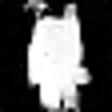

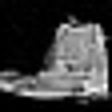

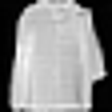

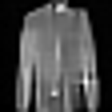

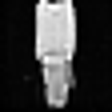

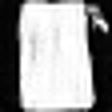

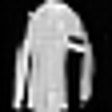

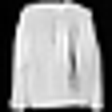

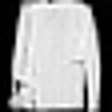

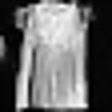

Training images: 


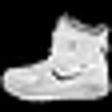

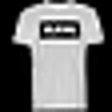

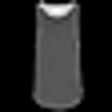

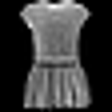

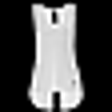

In [36]:
with t.inference_mode():
    samples = sample_ddim(model, n_samples=10, steps=50)

assert isinstance(samples, t.Tensor)
print("Generated images: ")
for s in samples:
    img = reverse_transform(s.cpu())
    display(img.resize((4 * 28, 4 * 28)))

print("Training images: ")
(xs,) = train_dataset[:5]
for x in xs:
    display(reverse_transform(x).resize((4 * 28, 4 * 28)))


100%|██████████| 1000/1000 [00:18<00:00, 52.70it/s]

Generated images: 


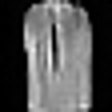

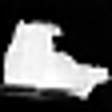

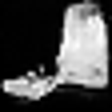

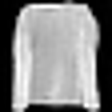

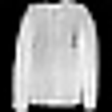

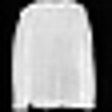

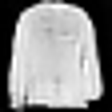

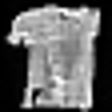

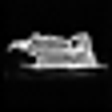

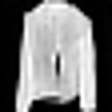

Training images: 


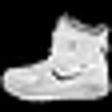

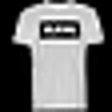

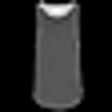

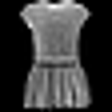

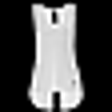

In [37]:
with t.inference_mode():
    samples = sample(model, n_samples=10)

assert isinstance(samples, t.Tensor)
print("Generated images: ")
for s in samples:
    img = reverse_transform(s.cpu())
    display(img.resize((4 * 28, 4 * 28)))

print("Training images: ")
(xs,) = train_dataset[:5]
for x in xs:
    display(reverse_transform(x).resize((4 * 28, 4 * 28)))


100%|██████████| 50/50 [00:01<00:00, 41.37it/s]

Printing sequential denoising: 
Step  0


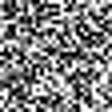

Step  2


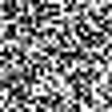

Step  4


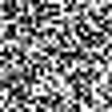

Step  6


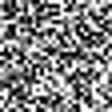

Step  8


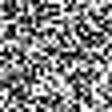

Step  10


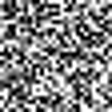

Step  12


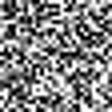

Step  14


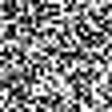

Step  16


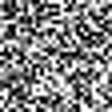

Step  18


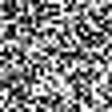

Step  20


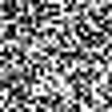

Step  22


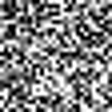

Step  24


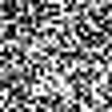

Step  26


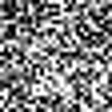

Step  28


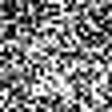

Step  30


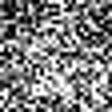

Step  32


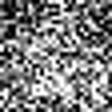

Step  34


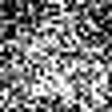

Step  36


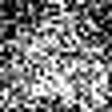

Step  38


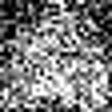

Step  40


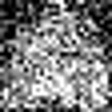

Step  42


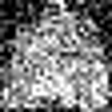

Step  44


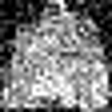

Step  46


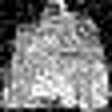

Step  48


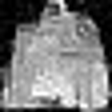

Step  50


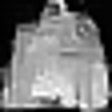

In [38]:
with t.inference_mode():
    samples = sample_ddim(model, n_samples=1, steps=50, return_all_steps=True)

print("Printing sequential denoising: ")
for i, s in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        print("Step ", i)
        img = reverse_transform(s[0].cpu())
        display(img.resize((4 * 28, 4 * 28)))

100%|██████████| 1000/1000 [00:15<00:00, 63.86it/s]

Printing sequential denoising: 
Step  0


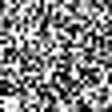

Step  50


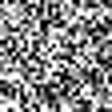

Step  100


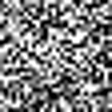

Step  150


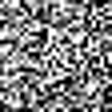

Step  200


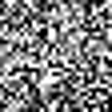

Step  250


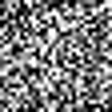

Step  300


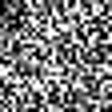

Step  350


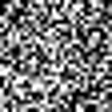

Step  400


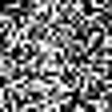

Step  450


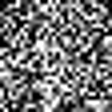

Step  500


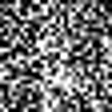

Step  550


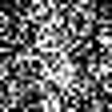

Step  600


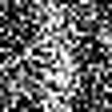

Step  650


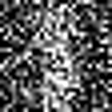

Step  700


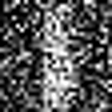

Step  750


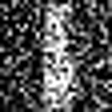

Step  800


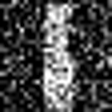

Step  850


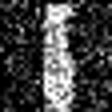

Step  900


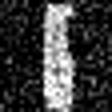

Step  950


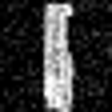

Step  1000


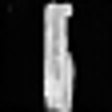

In [39]:
with t.inference_mode():
    samples = sample(model, n_samples=1, return_all_steps=True)

print("Printing sequential denoising: ")
for i, s in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        print("Step ", i)
        img = reverse_transform(s[0].cpu())
        display(img.resize((4 * 28, 4 * 28)))

# Classifier Guidance

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

# Initialize wandb
wandb.init(project="fashion-mnist-classifier")

# Hyperparameters
config = wandb.config
config.batch_size = 100
config.learning_rate = 0.001
config.num_epochs = 25
config.test_every_n_epochs = 3  # Test every 3 epochs

# Define the model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else "mps" if torch.mps.is_available() else 'cpu')

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]), download=True)

test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Watch the model
wandb.watch(model)

# Training loop
for epoch in range(config.num_epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs} (Train)")):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        batch_accuracy = (predicted == labels).sum().item() / labels.size(0)

        epoch_loss += loss.item()
        epoch_accuracy += batch_accuracy
        wandb.log({"batch_loss": loss.item(), "batch_accuracy": batch_accuracy})

    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(train_loader)
    wandb.log({"epoch": epoch + 1, "epoch_loss": avg_epoch_loss, "epoch_accuracy": avg_epoch_accuracy})
    print(f'Epoch [{epoch+1}/{config.num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Train Accuracy: {avg_epoch_accuracy:.4f}')

    # Test during training
    if (epoch + 1) % config.test_every_n_epochs == 0:
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_loss = 0
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{config.num_epochs} (Test)"):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = 100 * correct / total
            wandb.log({"epoch": epoch + 1, "test_loss": avg_test_loss, "test_accuracy": test_accuracy})
            print(f'Epoch [{epoch+1}/{config.num_epochs}], Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f} %')

wandb.finish()

# Save the model checkpoint
torch.save(model.state_dict(), 'fashion_mnist_cnn.pt')

Epoch 1/25 (Train):   0%|          | 0/600 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.12/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 68.95it/s]


Epoch [1/25], Train Loss: 0.4361, Train Accuracy: 0.8455


Epoch 2/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 69.68it/s]


Epoch [2/25], Train Loss: 0.2982, Train Accuracy: 0.8944


Epoch 3/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 73.45it/s]


Epoch [3/25], Train Loss: 0.2556, Train Accuracy: 0.9086


Epoch 3/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 153.24it/s]


Epoch [3/25], Test Loss: 0.2718, Test Accuracy: 90.51 %


Epoch 4/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 71.71it/s]


Epoch [4/25], Train Loss: 0.2321, Train Accuracy: 0.9166


Epoch 5/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 74.30it/s]


Epoch [5/25], Train Loss: 0.2164, Train Accuracy: 0.9220


Epoch 6/25 (Train): 100%|██████████| 600/600 [00:07<00:00, 75.54it/s]


Epoch [6/25], Train Loss: 0.2018, Train Accuracy: 0.9273


Epoch 6/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 169.57it/s]


Epoch [6/25], Test Loss: 0.2580, Test Accuracy: 91.01 %


Epoch 7/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 73.33it/s]


Epoch [7/25], Train Loss: 0.1832, Train Accuracy: 0.9339


Epoch 8/25 (Train): 100%|██████████| 600/600 [00:07<00:00, 76.14it/s]


Epoch [8/25], Train Loss: 0.1740, Train Accuracy: 0.9372


Epoch 9/25 (Train): 100%|██████████| 600/600 [00:07<00:00, 75.63it/s]


Epoch [9/25], Train Loss: 0.1596, Train Accuracy: 0.9425


Epoch 9/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 158.94it/s]


Epoch [9/25], Test Loss: 0.2802, Test Accuracy: 90.39 %


Epoch 10/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 72.13it/s]


Epoch [10/25], Train Loss: 0.1545, Train Accuracy: 0.9437


Epoch 11/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 74.09it/s]


Epoch [11/25], Train Loss: 0.1447, Train Accuracy: 0.9479


Epoch 12/25 (Train): 100%|██████████| 600/600 [00:07<00:00, 76.15it/s]


Epoch [12/25], Train Loss: 0.1333, Train Accuracy: 0.9511


Epoch 12/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 160.03it/s]


Epoch [12/25], Test Loss: 0.2911, Test Accuracy: 90.42 %


Epoch 13/25 (Train): 100%|██████████| 600/600 [00:07<00:00, 75.30it/s]


Epoch [13/25], Train Loss: 0.1265, Train Accuracy: 0.9538


Epoch 14/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 68.58it/s]


Epoch [14/25], Train Loss: 0.1209, Train Accuracy: 0.9551


Epoch 15/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 69.64it/s]


Epoch [15/25], Train Loss: 0.1137, Train Accuracy: 0.9584


Epoch 15/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 149.80it/s]


Epoch [15/25], Test Loss: 0.3103, Test Accuracy: 91.12 %


Epoch 16/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 74.64it/s]


Epoch [16/25], Train Loss: 0.1069, Train Accuracy: 0.9601


Epoch 17/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 72.63it/s]


Epoch [17/25], Train Loss: 0.0990, Train Accuracy: 0.9636


Epoch 18/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 74.94it/s]


Epoch [18/25], Train Loss: 0.0969, Train Accuracy: 0.9643


Epoch 18/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 154.44it/s]


Epoch [18/25], Test Loss: 0.3402, Test Accuracy: 90.85 %


Epoch 19/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 70.17it/s]


Epoch [19/25], Train Loss: 0.0900, Train Accuracy: 0.9672


Epoch 20/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 69.16it/s]


Epoch [20/25], Train Loss: 0.0846, Train Accuracy: 0.9694


Epoch 21/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 71.44it/s]


Epoch [21/25], Train Loss: 0.0802, Train Accuracy: 0.9710


Epoch 21/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 142.17it/s]


Epoch [21/25], Test Loss: 0.3738, Test Accuracy: 90.48 %


Epoch 22/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 69.40it/s]


Epoch [22/25], Train Loss: 0.0773, Train Accuracy: 0.9713


Epoch 23/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 72.79it/s]


Epoch [23/25], Train Loss: 0.0751, Train Accuracy: 0.9724


Epoch 24/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 74.27it/s]


Epoch [24/25], Train Loss: 0.0717, Train Accuracy: 0.9742


Epoch 24/25 (Test): 100%|██████████| 100/100 [00:00<00:00, 168.73it/s]


Epoch [24/25], Test Loss: 0.3903, Test Accuracy: 90.44 %


Epoch 25/25 (Train): 100%|██████████| 600/600 [00:08<00:00, 66.97it/s]


Epoch [25/25], Train Loss: 0.0710, Train Accuracy: 0.9739


batch_accuracy,▃▄▃▁▅▅▇▄▄▃▆▅▆▅▅▇▄▆▅▅▇▆▆▅▅▅█▅▇▇▇▇▄▇▅▆▇▃▇█
batch_loss,▆█▃▅▃▃▄▃▂▃▂▃▃▃▂▃▂▃▂▂▁▁▂▂▂▁▂▂▁▁▂▃▂▁▂▂▁▁▂▂
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch_accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████
epoch_loss,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▂▇▁▁█▅▂▁
test_loss,▂▁▂▃▄▅▇█
batch_accuracy,0.96
batch_loss,0.08872
epoch,25
epoch_accuracy,0.97393


In [46]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def sample_images_from_class(
    diffusion_model,
    classifier_model,
    class_index,
    num_images,
    num_sampling_steps,
    image_size,
    guidance_scale=1.5,
    device="cuda",
):
    """
    Generates images of a specific class using classifier-guided diffusion.

    Args:
        diffusion_model: Your trained DDPM model (with Unet and NoiseSchedule).
        classifier_model: The trained classifier model.
        class_index: The index of the class to generate (0 to num_classes-1).
        num_images: The number of images to generate.
        num_sampling_steps: The number of diffusion timesteps for sampling.
        image_size: The size of the generated images (e.g., (1, 28, 28) for FashionMNIST).
        guidance_scale: The scale factor for classifier guidance.
        device: The device to perform computations on.

    Returns:
        A tensor of generated images.
    """

    # 1. Get Noise Schedule:
    noise_schedule = diffusion_model.noise_schedule

    # 2. Initialize Samples:
    x = torch.randn((num_images, *image_size), device=device)

    # 3. Class Labels (for conditional sampling):
    # Create labels all corresponding to the desired class_index
    labels = torch.full((num_images,), class_index, device=device, dtype=torch.long)
    one_hot_labels = F.one_hot(
        labels, num_classes=classifier_model.fc2.out_features
    ).float()  # Get num_classes from classifier

    # 4. Sampling Loop:
    for i in tqdm(
        reversed(range(0, num_sampling_steps)),
        desc="Sampling",
        total=num_sampling_steps,
    ):
        t = torch.full((num_images,), i, device=device, dtype=torch.long)

        # 4.1. Classifier Prediction (and Gradient Calculation):
        with torch.enable_grad():
            x_in = x.detach().requires_grad_(True)
            classifier_logits = classifier_model(x_in)
            log_probs = F.log_softmax(classifier_logits, dim=-1)
            selected = log_probs[range(len(log_probs)), labels]  # Select log_probs of the desired class
            classifier_grad = (
                torch.autograd.grad(selected.sum(), x_in)[0] * guidance_scale
            )

        # 4.2. DDPM Denoising Step:
        model_output = diffusion_model(x, t)

        # 4.3. Apply Classifier Guidance:
        alpha_t = noise_schedule.alpha(t)
        alpha_bar_t = noise_schedule.alpha_bar(t)
        beta_t = noise_schedule.beta(t)
        sigma_t = torch.sqrt(beta_t)

        if guidance_scale > 0.0:
            # Add the classifier gradient to the mean prediction
            pred_mean = (
                1
                / torch.sqrt(alpha_t)
            ).view(-1, 1, 1, 1) * (
                x
                - (1 - alpha_t).view(-1, 1, 1, 1)
                / torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1)
                * model_output
            ) + classifier_grad
        else:
            pred_mean = (
                1
                / torch.sqrt(alpha_t)
            ).view(-1, 1, 1, 1) * (
                x
                - (1 - alpha_t).view(-1, 1, 1, 1)
                / torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1)
                * model_output
            )

        # 4.4. Predict Previous Sample (x_{t-1}):
        if i > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = pred_mean + sigma_t.view(-1, 1, 1, 1) * noise

    return x  # Return only the generated images

In [44]:
diffusion_model = Unet(
    max_steps=config_dict["max_steps"],
    channels=config_dict["model_channels"],
    image_shape=config_dict["image_shape"],
    dim_mults=config_dict["model_dim_mults"],
).to(config_dict["device"])
assert isinstance(data_folder, Path)
MODEL_FILENAME = data_folder / "unet_model_thousand.pt"
if MODEL_FILENAME.exists():
    diffusion_model = Unet(
        max_steps=config_dict["max_steps"],
        channels=config_dict["model_channels"],
        image_shape=config_dict["image_shape"],
        dim_mults=config_dict["model_dim_mults"],
    ).to(config_dict["device"])
    diffusion_model.noise_schedule = NoiseSchedule(config_dict["max_steps"], config_dict["device"])
    diffusion_model.load_state_dict(t.load(str(MODEL_FILENAME)))

Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]
Channel sizes for in/out: [(28, 28), (28, 56), (56, 112)]


/var/folders/sm/byz3skxx5c57sw2mzmy66j240000gn/T/ipykernel_63010/3120068008.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_model.load_state_dict(t.load(str(M

In [50]:
api.upload_file(
    path_or_fileobj="./data/w3d4/simple_classifier.pt",
    path_in_repo="fashionmnist-classifier-simple.pt",
    repo_id="michaelyliu6/fashionmnist-classifier",
    repo_type="model",
    create_pr=False
)

simple_classifier.pt:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/michaelyliu6/fashionmnist-classifier/commit/a048c8a3263fbbe64768787a8f7eb1f634b121f2', commit_message='Upload fashionmnist-classifier-simple.pt with huggingface_hub', commit_description='', oid='a048c8a3263fbbe64768787a8f7eb1f634b121f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/michaelyliu6/fashionmnist-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='michaelyliu6/fashionmnist-classifier'), pr_revision=None, pr_num=None)

In [48]:
# Example: Generate 16 images of class 3 (e.g., "Dress" in FashionMNIST)

class_index = 3  # The class you want to generate
num_images = 16
image_size = (1, 28, 28)
guidance_scale = 1.5
model = model.to("mps")

generated_images = sample_images_from_class(
    diffusion_model,
    model,
    class_index,
    num_images,
    num_sampling_steps=diffusion_model.noise_schedule.max_steps,
    image_size=image_size,
    guidance_scale=guidance_scale,
    device="mps",  # Or "cpu"
)

# generated_images now contains the generated images (no labels)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:  20%|█▉        | 198/1000 [00:32<02:13,  6.02it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 61.20 GB, other allocations: 4.09 MB, max allowed: 61.20 GB). Tried to allocate 1.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Load and prepare the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Instantiate model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Epoch [1/5], Step [100/938], Loss: 0.5325
Epoch [1/5], Step [200/938], Loss: 0.4858
Epoch [1/5], Step [300/938], Loss: 0.4920
Epoch [1/5], Step [400/938], Loss: 0.2831
Epoch [1/5], Step [500/938], Loss: 0.2057
Epoch [1/5], Step [600/938], Loss: 0.3146
Epoch [1/5], Step [700/938], Loss: 0.4195
Epoch [1/5], Step [800/938], Loss: 0.3406
Epoch [1/5], Step [900/938], Loss: 0.4114
Epoch [2/5], Step [100/938], Loss: 0.3282
Epoch [2/5], Step [200/938], Loss: 0.3629
Epoch [2/5], Step [300/938], Loss: 0.1165
Epoch [2/5], Step [400/938], Loss: 0.2111
Epoch [2/5], Step [500/938], Loss: 0.4014
Epoch [2/5], Step [600/938], Loss: 0.2021
Epoch [2/5], Step [700/938], Loss: 0.2076
Epoch [2/5], Step [800/938], Loss: 0.1669
Epoch [2/5], Step [900/938], Loss: 0.4524
Epoch [3/5], Step [100/938], Loss: 0.3151
Epoch [3/5], Step [200/938], Loss: 0.1775
Epoch [3/5], Step [300/938], Loss: 0.2156
Epoch [3/5], Step [400/938], Loss: 0.1396
Epoch [3/5], Step [500/938], Loss: 0.2264
Epoch [3/5], Step [600/938], Loss:

In [40]:
torch.save(model.state_dict(), 'simple_classifier.pt')